In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import nltk
import transformers
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from gensim.models import Word2Vec, word2vec
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
from PIL import Image
import natsort
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import clip

import torch
from transformers import AutoTokenizer, DistilBertModel
import time
import random
import tensorflow as tf
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import mse
from keras import backend as K
from tensorflow.keras.layers import Dropout
TF_ENABLE_ONEDNN_OPTS=0

2023-07-15 01:37:52.563389: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## BASIC UTIL FUNCTION

In [2]:
def export_classification_report(report, mod, exec_time):
    lines = report.split('\n')
    data = lines[2:4] + lines[5:9]
    data = [line.split() for line in data]
    

    acc = float(data[2][1])
    m_prec = float(data[3][2])
    m_recall = float(data[3][3])
    m_f1 = float(data[3][4])
    w_prec = float(data[4][2])
    w_recall = float(data[4][3])
    w_f1 = float(data[4][4])
    
    df = pd.DataFrame({
        'Model': [mod],
        'Accuracy': [acc],
        'M-Precision': [m_prec],
        'M-Recall': [m_recall],
        'M-F1-Score': [m_f1],
        'W-Precision': [w_prec],
        'W-Recall': [w_recall],
        'W-F1-Score': [w_f1],
        'Runtime': [exec_time]
    })
    
    return df

def add_salt_and_pepper(image, salt_prob=0.05, pepper_prob=0.05):
    np_image = np.array(image)
    height, width, _  = np_image.shape
    salt_pixels = np.random.choice([True, False], size=(height, width), p=[salt_prob, 1-salt_prob])
    pepper_pixels = np.random.choice([True, False], size=(height, width), p=[pepper_prob, 1-pepper_prob])
    np_image[salt_pixels] = [255, 255, 255]  # Set salt pixels to white
    np_image[pepper_pixels] = [0, 0, 0]  # Set pepper pixels to black
    return Image.fromarray(np_image)


## DATA PREPARATION

In [3]:
# Load the data


#  DistilBERT Embeddings (Text Only); (Train and Test Data Embeddings)

train2 = pd.read_csv('./training1.csv', delimiter='\t')

IDs = []  #set1
images = []
directory = 'TRAINING'   # directory where we have images 
filenames = natsort.natsorted(os.listdir(directory))  

# get the ids from the images, where images are having three channels; omit images if channels != 3
for i, filename in enumerate(filenames):
#     print(i, filename)
    if filename.endswith(".jpg"):
#         ID = int(filename[:-4])
        ID = filename
        pathname = os.path.join(directory, filename)
        im = Image.open(pathname)
        im = im.resize((224, 224))  # Resize the image to (224, 224)
        imnp = np.array(im)
        if len(imnp.shape) != 3:
#             print("This is 1 channel, so we omit it", imnp.shape, filename)
            continue
        IDs.append(ID)
        images.append(imnp)

def get_common_strings(list1, list2):
    return list(set(list1) & set(list2))

# Example usage
list1 = IDs
list2 = list(train2.file_name)  #from the text file where we have text description 
common_strings = get_common_strings(list1, list2)
print('len of common strings', len(common_strings))

sorted_ids = natsort.natsorted(common_strings)

# print(sorted_ids)

# Sort the dataframe with natural ordering of the IDs
train2['prefix_file_name'] = train2['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
sorted_train_df = train2.sort_values(by='prefix_file_name', ascending=True)
sorted_train_df

# Assuming 'df' is your DataFrame and 'common_strings' is the list of strings
# Get the common string values in the column 
filtered_df = sorted_train_df[sorted_train_df['file_name'].isin(sorted_ids)].reset_index(drop=True)

# Print the filtered DataFrame
print('filtered_df shape', filtered_df.shape)

train3 = filtered_df.copy()
# print(train3.shape)

trainx = train3.rename(columns={'Text Transcription': 'text'})
# display(trainx)



### LOAD TEST DATA

test1 = pd.read_csv('Test.csv', delimiter='\t')
test_labels = pd.read_csv('test_labels.txt', 
                          delimiter='\t',
                         header=None)

test_labels.columns = ['file_name', 
                      "misogynous",
                       "shaming",
                       "stereotype",
                       "objectification",
                       "violence"]

merged_test = pd.merge(test1, test_labels, on='file_name', how='inner')


# Sort the dataframe with natural ordering of the IDs
merged_test['prefix_file_name'] = merged_test['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
merged_test1 = merged_test.sort_values(by='prefix_file_name', ascending=True)
merged_test1


# # train = train.rename(columns={'Text Transcription': 'text'})
test2 = merged_test1.rename(columns={'Text Transcription': 'text'})
# test2



# ######################################################
train = trainx[['file_name', 'text', 'misogynous']]
train = train.rename(columns = {'misogynous':'label'})

test = test2[['file_name', 'text', 'misogynous']]
test = test.rename(columns = {'misogynous':'label'})

train['label'] = train['label'].map({0: 'non_misogyn', 1: 'misogyn'})
test['label'] = test['label'].map({0: 'non_misogyn', 1: 'misogyn'})
display(train)
display(test)

len of common strings 9986
filtered_df shape (9986, 8)


,file_name,text,label
0,1.jpg,Milk Milk.zip,non_misogyn
1,2.jpg,-What are you doing? -you told me to satanize ...,non_misogyn
2,3.jpg,imgflip.com ME 1254 NEW BUGS AFTER CHANGES BUG...,non_misogyn
3,4.jpg,Bedroom Kitchen Bathroom Bron memes storage,non_misogyn
4,5.jpg,WAKEUP EARLY FREELANCERS,non_misogyn
...,...,...,...
9981,15002.jpg,WAITING FOR THE END OF THE COVID imgflip.com,non_misogyn
9982,15003.jpg,SMART WOMEN ARE AROUND imgflip.com,non_misogyn
9983,15004.jpg,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,non_misogyn
9984,15005.jpg,COOKING FOR MY WIFE imgflip.com,non_misogyn


,file_name,text,label
436,15001.jpg,G HIS. UNDYING FIDELITY Steve is hot and perfe...,non_misogyn
854,15002.jpg,How limagined myself as a Teacher...... How I ...,non_misogyn
743,15004.jpg,WHERE WILL YOU BE WHEN DIARRHEA STRIKE memecen...,non_misogyn
44,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,non_misogyn
873,15006.jpg,THIS IS HOW YOUR GIRLFRIEND SEES YOUR FEMALE F...,non_misogyn
...,...,...,...
871,17078.jpg,There are multiple reasons to lower your car T...,non_misogyn
683,17079.jpg,MICHELLE OBAMA IS A MAN IGUARANTEE IT makeamem...,misogyn
406,17080.jpg,Looks like the airbags deployed 1234498,non_misogyn
733,17081.jpg,Half woman half horse,non_misogyn


## ALL THREE METHODS RUN FOR FEATURE EXTRACTION

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                        

2023-07-15 01:43:14.922938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 01:43:14.950257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 01:43:14.950371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 01:43:14.950703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10
111/313 [=========>....................] - ETA: 0s - loss: 94.9782 - kl_loss: 0.9891 - mse_loss: 93.9890  

2023-07-15 01:43:15.627282: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 1s 1ms/step - loss: 83.7782 - kl_loss: 0.6145 - mse_loss: 83.1637
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 75.2458 - kl_loss: 0.5317 - mse_loss: 74.7140
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 73.8679 - kl_loss: 0.6514 - mse_loss: 73.2166
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 73.0173 - kl_loss: 0.7367 - mse_loss: 72.2806
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 72.3497 - kl_loss: 0.7988 - mse_loss: 71.5510
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 71.9294 - kl_loss: 0.8545 - mse_loss: 71.0749
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 71.4410 - kl_loss: 0.8980 - mse_loss: 70.5430
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 71.0628 - kl_loss: 0.9280 - mse_loss: 70.1347
Epoch 9/10
313/313 [==============================]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)


/home/nitesh/env/dev38/python38/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-error:0.20205	validation_0-logloss:0.68518	validation_1-error:0.29029	validation_1-logloss:0.68727
[1]	validation_0-error:0.19492	validation_0-logloss:0.67755	validation_1-error:0.27828	validation_1-logloss:0.68149
[2]	validation_0-error:0.19429	validation_0-logloss:0.67020	validation_1-error:0.27177	validation_1-logloss:0.67600
[3]	validation_0-error:0.19179	validation_0-logloss:0.66305	validation_1-error:0.26727	validation_1-logloss:0.67061
[4]	validation_0-error:0.18440	validation_0-logloss:0.65608	validation_1-error:0.26426	validation_1-logloss:0.66555
[5]	validation_0-error:0.17414	validation_0-logloss:0.64945	validation_1-error:0.25676	validation_1-logloss:0.66056
[6]	validation_0-error:0.17601	validation_0-logloss:0.64291	validation_1-error:0.25926	validation_1-logloss:0.65608
[7]	validation_0-error:0.17251	validation_0-logloss:0.63665	validation_1-error:0.25776	validation_1-logloss:0.65148
[8]	validation_0-error:0.17013	validation_0-logloss:0.63047	validation_1

[71]	validation_0-error:0.11693	validation_0-logloss:0.41236	validation_1-error:0.22122	validation_1-logloss:0.50704
[72]	validation_0-error:0.11580	validation_0-logloss:0.41013	validation_1-error:0.22022	validation_1-logloss:0.50601
[73]	validation_0-error:0.11580	validation_0-logloss:0.40822	validation_1-error:0.21822	validation_1-logloss:0.50502
[74]	validation_0-error:0.11530	validation_0-logloss:0.40623	validation_1-error:0.22022	validation_1-logloss:0.50391
[75]	validation_0-error:0.11430	validation_0-logloss:0.40420	validation_1-error:0.21872	validation_1-logloss:0.50252
[76]	validation_0-error:0.11342	validation_0-logloss:0.40231	validation_1-error:0.21772	validation_1-logloss:0.50148
[77]	validation_0-error:0.11267	validation_0-logloss:0.40028	validation_1-error:0.21772	validation_1-logloss:0.50051
[78]	validation_0-error:0.11204	validation_0-logloss:0.39840	validation_1-error:0.21672	validation_1-logloss:0.49966
[79]	validation_0-error:0.11117	validation_0-logloss:0.39644	val

[141]	validation_0-error:0.08513	validation_0-logloss:0.31063	validation_1-error:0.20871	validation_1-logloss:0.46185
[142]	validation_0-error:0.08463	validation_0-logloss:0.30961	validation_1-error:0.20721	validation_1-logloss:0.46139
[143]	validation_0-error:0.08488	validation_0-logloss:0.30875	validation_1-error:0.20721	validation_1-logloss:0.46107
[144]	validation_0-error:0.08363	validation_0-logloss:0.30751	validation_1-error:0.20671	validation_1-logloss:0.46069
[145]	validation_0-error:0.08350	validation_0-logloss:0.30640	validation_1-error:0.20721	validation_1-logloss:0.46038
[146]	validation_0-error:0.08275	validation_0-logloss:0.30556	validation_1-error:0.20671	validation_1-logloss:0.46020
[147]	validation_0-error:0.08275	validation_0-logloss:0.30433	validation_1-error:0.20621	validation_1-logloss:0.45978
[148]	validation_0-error:0.08237	validation_0-logloss:0.30314	validation_1-error:0.20621	validation_1-logloss:0.45936
[149]	validation_0-error:0.08162	validation_0-logloss:0.

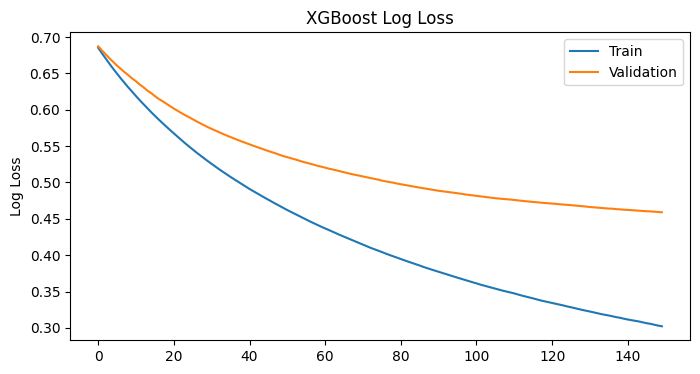

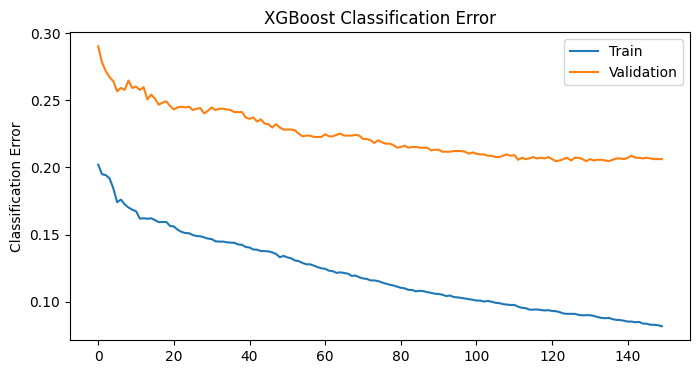

              precision    recall  f1-score   support

           0       0.85      0.49      0.62       500
           1       0.64      0.92      0.76       500

    accuracy                           0.70      1000
   macro avg       0.75      0.70      0.69      1000
weighted avg       0.75      0.70      0.69      1000

Execution time: 351.1372721195221 seconds


/tmp/ipykernel_52636/2551013453.py:530: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_5[0][0]']                
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19567	validation_0-logloss:0.68461	validation_1-error:0.27527	validation_1-logloss:0.68658
[1]	validation_0-error:0.18378	validation_0-logloss:0.67633	validation_1-error:0.25776	validation_1-logloss:0.68009
[2]	validation_0-error:0.18127	validation_0-logloss:0.66839	validation_1-error:0.25576	validation_1-logloss:0.67384
[3]	validation_0-error:0.17576	validation_0-logloss:0.66063	validation_1-error:0.25275	validation_1-logloss:0.66782
[4]	validation_0-error:0.18077	validation_0-logloss:0.65320	validation_1-error:0.25175	validation_1-logloss:0.66218
[5]	validation_0-error:0.17702	validation_0-logloss:0.64588	validation_1-error:0.24975	validation_1-logloss:0.65652
[6]	validation_0-error:0.17276	validation_0-logloss:0.63882	validation_1-error:0.24825	validation_1-logloss:0.65098
[7]	validation_0-error:0.16838	validation_0-logloss:0.63196	validation_1-error:0.24274	validation_1-logloss:0.64579
[

[70]	validation_0-error:0.12181	validation_0-logloss:0.40108	validation_1-error:0.21371	validation_1-logloss:0.48683
[71]	validation_0-error:0.12218	validation_0-logloss:0.39911	validation_1-error:0.21471	validation_1-logloss:0.48558
[72]	validation_0-error:0.12106	validation_0-logloss:0.39712	validation_1-error:0.21421	validation_1-logloss:0.48446
[73]	validation_0-error:0.12030	validation_0-logloss:0.39510	validation_1-error:0.21321	validation_1-logloss:0.48329
[74]	validation_0-error:0.12005	validation_0-logloss:0.39325	validation_1-error:0.21421	validation_1-logloss:0.48228
[75]	validation_0-error:0.12056	validation_0-logloss:0.39128	validation_1-error:0.21521	validation_1-logloss:0.48149
[76]	validation_0-error:0.11980	validation_0-logloss:0.38944	validation_1-error:0.21321	validation_1-logloss:0.48037
[77]	validation_0-error:0.11930	validation_0-logloss:0.38764	validation_1-error:0.21321	validation_1-logloss:0.47937
[78]	validation_0-error:0.11893	validation_0-logloss:0.38586	val

[140]	validation_0-error:0.09402	validation_0-logloss:0.30376	validation_1-error:0.20520	validation_1-logloss:0.44201
[141]	validation_0-error:0.09352	validation_0-logloss:0.30269	validation_1-error:0.20621	validation_1-logloss:0.44187
[142]	validation_0-error:0.09352	validation_0-logloss:0.30178	validation_1-error:0.20621	validation_1-logloss:0.44150
[143]	validation_0-error:0.09264	validation_0-logloss:0.30061	validation_1-error:0.20621	validation_1-logloss:0.44118
[144]	validation_0-error:0.09226	validation_0-logloss:0.29973	validation_1-error:0.20571	validation_1-logloss:0.44074
[145]	validation_0-error:0.09239	validation_0-logloss:0.29875	validation_1-error:0.20470	validation_1-logloss:0.44035
[146]	validation_0-error:0.09251	validation_0-logloss:0.29790	validation_1-error:0.20470	validation_1-logloss:0.44005
[147]	validation_0-error:0.09176	validation_0-logloss:0.29694	validation_1-error:0.20470	validation_1-logloss:0.43956
[148]	validation_0-error:0.09151	validation_0-logloss:0.

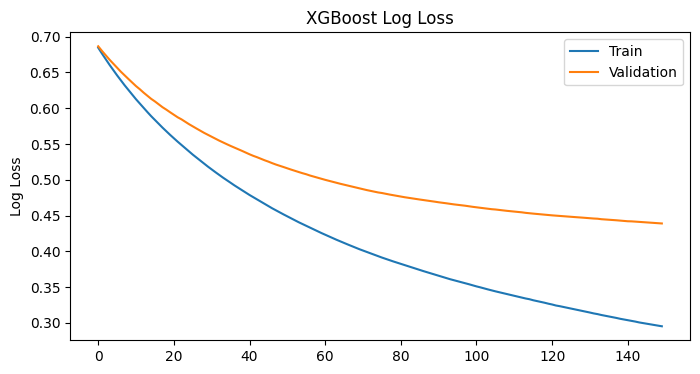

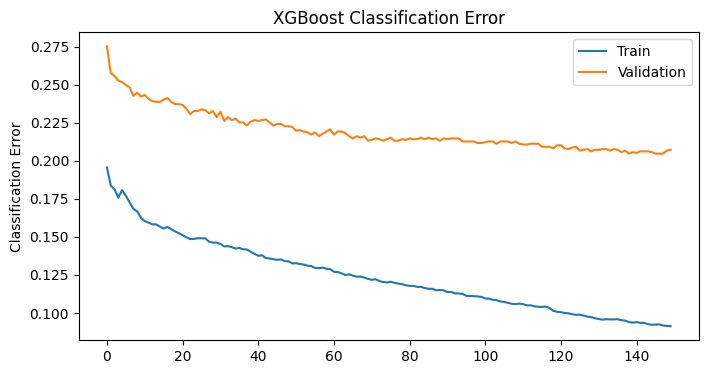

              precision    recall  f1-score   support

           0       0.86      0.51      0.64       500
           1       0.65      0.92      0.76       500

    accuracy                           0.71      1000
   macro avg       0.76      0.72      0.70      1000
weighted avg       0.76      0.71      0.70      1000

Execution time: 373.82909393310547 seconds


/tmp/ipykernel_52636/2551013453.py:530: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['dense_10[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19805	validation_0-logloss:0.68492	validation_1-error:0.26326	validation_1-logloss:0.68653
[1]	validation_0-error:0.19604	validation_0-logloss:0.67700	validation_1-error:0.25826	validation_1-logloss:0.68027
[2]	validation_0-error:0.19191	validation_0-logloss:0.66939	validation_1-error:0.25926	validation_1-logloss:0.67418
[3]	validation_0-error:0.19041	validation_0-logloss:0.66196	validation_1-error:0.25425	validation_1-logloss:0.66817
[4]	validation_0-error:0.19016	validation_0-logloss:0.65479	validation_1-error:0.24625	validation_1-logloss:0.66250
[5]	validation_0-error:0.18741	validation_0-logloss:0.64786	validation_1-error:0.24274	validation_1-logloss:0.65690
[6]	validation_0-error:0.18565	validation_0-logloss:0.64116	validation_1-error:0.24374	validation_1-logloss:0.65158
[7]	validation_0-error:0.18415	validation_0-logloss:0.63460	validation_1-error:0.24074	validation_1-logloss:0.64645
[

[70]	validation_0-error:0.12281	validation_0-logloss:0.41099	validation_1-error:0.21922	validation_1-logloss:0.49553
[71]	validation_0-error:0.12306	validation_0-logloss:0.40884	validation_1-error:0.21822	validation_1-logloss:0.49421
[72]	validation_0-error:0.12268	validation_0-logloss:0.40675	validation_1-error:0.21822	validation_1-logloss:0.49302
[73]	validation_0-error:0.12243	validation_0-logloss:0.40479	validation_1-error:0.21722	validation_1-logloss:0.49191
[74]	validation_0-error:0.12268	validation_0-logloss:0.40282	validation_1-error:0.21622	validation_1-logloss:0.49079
[75]	validation_0-error:0.12181	validation_0-logloss:0.40078	validation_1-error:0.21521	validation_1-logloss:0.48962
[76]	validation_0-error:0.12118	validation_0-logloss:0.39885	validation_1-error:0.21371	validation_1-logloss:0.48859
[77]	validation_0-error:0.12156	validation_0-logloss:0.39707	validation_1-error:0.21421	validation_1-logloss:0.48756
[78]	validation_0-error:0.12043	validation_0-logloss:0.39503	val

[140]	validation_0-error:0.08876	validation_0-logloss:0.30895	validation_1-error:0.20120	validation_1-logloss:0.44726
[141]	validation_0-error:0.08851	validation_0-logloss:0.30786	validation_1-error:0.19970	validation_1-logloss:0.44705
[142]	validation_0-error:0.08838	validation_0-logloss:0.30694	validation_1-error:0.19970	validation_1-logloss:0.44677
[143]	validation_0-error:0.08776	validation_0-logloss:0.30593	validation_1-error:0.20020	validation_1-logloss:0.44654
[144]	validation_0-error:0.08751	validation_0-logloss:0.30493	validation_1-error:0.19920	validation_1-logloss:0.44613
[145]	validation_0-error:0.08713	validation_0-logloss:0.30381	validation_1-error:0.19970	validation_1-logloss:0.44572
[146]	validation_0-error:0.08701	validation_0-logloss:0.30285	validation_1-error:0.19920	validation_1-logloss:0.44537
[147]	validation_0-error:0.08663	validation_0-logloss:0.30186	validation_1-error:0.19970	validation_1-logloss:0.44505
[148]	validation_0-error:0.08675	validation_0-logloss:0.

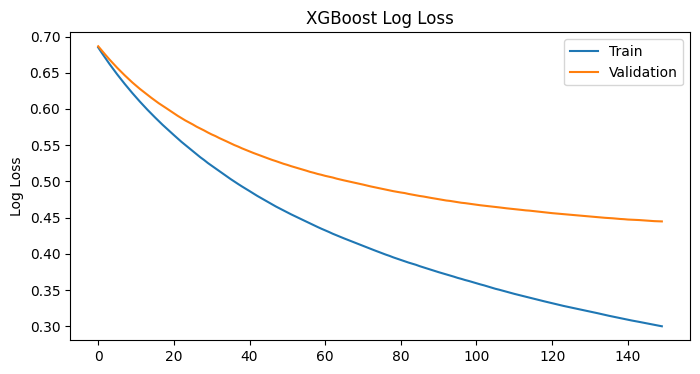

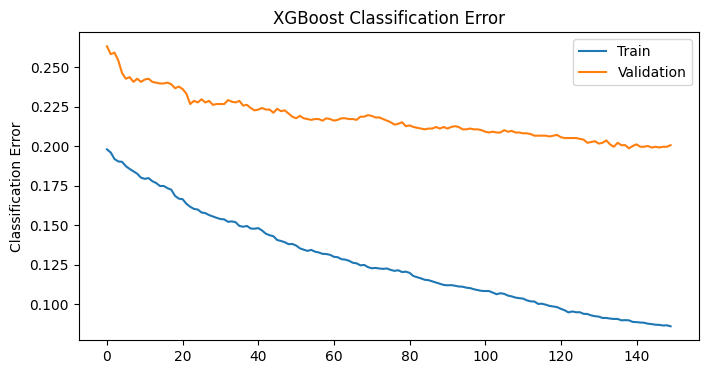

/tmp/ipykernel_52636/2551013453.py:530: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.85      0.50      0.63       500
           1       0.65      0.91      0.76       500

    accuracy                           0.71      1000
   macro avg       0.75      0.71      0.69      1000
weighted avg       0.75      0.71      0.69      1000

Execution time: 372.16502022743225 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_6 (Dropout)            (None, 128)          0           ['dense_15[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.20293	validation_0-logloss:0.68507	validation_1-error:0.26226	validation_1-logloss:0.68658
[1]	validation_0-error:0.20243	validation_0-logloss:0.67726	validation_1-error:0.26026	validation_1-logloss:0.68034
[2]	validation_0-error:0.20068	validation_0-logloss:0.66977	validation_1-error:0.25676	validation_1-logloss:0.67434
[3]	validation_0-error:0.19805	validation_0-logloss:0.66245	validation_1-error:0.26126	validation_1-logloss:0.66850
[4]	validation_0-error:0.19054	validation_0-logloss:0.65525	validation_1-error:0.25526	validation_1-logloss:0.66283
[5]	validation_0-error:0.18728	validation_0-logloss:0.64839	validation_1-error:0.25025	validation_1-logloss:0.65766
[6]	validation_0-error:0.18065	validation_0-logloss:0.64159	validation_1-error:0.24524	validation_1-logloss:0.65236
[7]	validation_0-error:0.17964	validation_0-logloss:0.63521	validation_1-error:0.24174	validation_1-logloss:0.64749
[

[70]	validation_0-error:0.12118	validation_0-logloss:0.41250	validation_1-error:0.20671	validation_1-logloss:0.49067
[71]	validation_0-error:0.12118	validation_0-logloss:0.41042	validation_1-error:0.20721	validation_1-logloss:0.48962
[72]	validation_0-error:0.12005	validation_0-logloss:0.40849	validation_1-error:0.20621	validation_1-logloss:0.48841
[73]	validation_0-error:0.11955	validation_0-logloss:0.40659	validation_1-error:0.20721	validation_1-logloss:0.48741
[74]	validation_0-error:0.11905	validation_0-logloss:0.40475	validation_1-error:0.20721	validation_1-logloss:0.48637
[75]	validation_0-error:0.11893	validation_0-logloss:0.40276	validation_1-error:0.20571	validation_1-logloss:0.48530
[76]	validation_0-error:0.11768	validation_0-logloss:0.40102	validation_1-error:0.20721	validation_1-logloss:0.48416
[77]	validation_0-error:0.11718	validation_0-logloss:0.39917	validation_1-error:0.20470	validation_1-logloss:0.48314
[78]	validation_0-error:0.11643	validation_0-logloss:0.39718	val

[140]	validation_0-error:0.09114	validation_0-logloss:0.31325	validation_1-error:0.18919	validation_1-logloss:0.44243
[141]	validation_0-error:0.09064	validation_0-logloss:0.31219	validation_1-error:0.19019	validation_1-logloss:0.44206
[142]	validation_0-error:0.09026	validation_0-logloss:0.31117	validation_1-error:0.19069	validation_1-logloss:0.44182
[143]	validation_0-error:0.08976	validation_0-logloss:0.31036	validation_1-error:0.19069	validation_1-logloss:0.44159
[144]	validation_0-error:0.08938	validation_0-logloss:0.30957	validation_1-error:0.19019	validation_1-logloss:0.44126
[145]	validation_0-error:0.08876	validation_0-logloss:0.30849	validation_1-error:0.19119	validation_1-logloss:0.44096
[146]	validation_0-error:0.08876	validation_0-logloss:0.30743	validation_1-error:0.19119	validation_1-logloss:0.44071
[147]	validation_0-error:0.08838	validation_0-logloss:0.30644	validation_1-error:0.18869	validation_1-logloss:0.44034
[148]	validation_0-error:0.08788	validation_0-logloss:0.

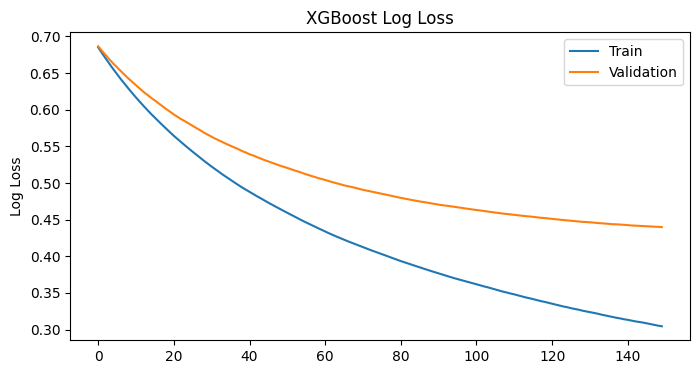

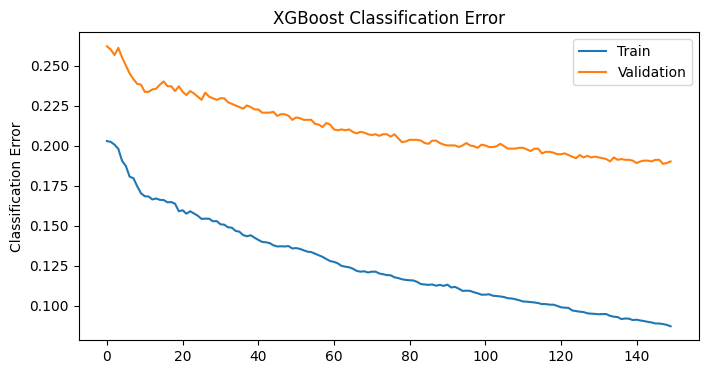

/tmp/ipykernel_52636/2551013453.py:530: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.86      0.43      0.57       500
           1       0.62      0.93      0.74       500

    accuracy                           0.68      1000
   macro avg       0.74      0.68      0.66      1000
weighted avg       0.74      0.68      0.66      1000

Execution time: 375.7913203239441 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 128)          0           ['dense_20[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19692	validation_0-logloss:0.68477	validation_1-error:0.25626	validation_1-logloss:0.68642
[1]	validation_0-error:0.19191	validation_0-logloss:0.67674	validation_1-error:0.25125	validation_1-logloss:0.67999
[2]	validation_0-error:0.18928	validation_0-logloss:0.66899	validation_1-error:0.25025	validation_1-logloss:0.67372
[3]	validation_0-error:0.18090	validation_0-logloss:0.66144	validation_1-error:0.24625	validation_1-logloss:0.66770
[4]	validation_0-error:0.18177	validation_0-logloss:0.65419	validation_1-error:0.24725	validation_1-logloss:0.66184
[5]	validation_0-error:0.17764	validation_0-logloss:0.64706	validation_1-error:0.23724	validation_1-logloss:0.65634
[6]	validation_0-error:0.17564	validation_0-logloss:0.64029	validation_1-error:0.24124	validation_1-logloss:0.65106
[7]	validation_0-error:0.17639	validation_0-logloss:0.63367	validation_1-error:0.24174	validation_1-logloss:0.64595
[

[70]	validation_0-error:0.12844	validation_0-logloss:0.40747	validation_1-error:0.21471	validation_1-logloss:0.49033
[71]	validation_0-error:0.12819	validation_0-logloss:0.40562	validation_1-error:0.21622	validation_1-logloss:0.48924
[72]	validation_0-error:0.12794	validation_0-logloss:0.40358	validation_1-error:0.21371	validation_1-logloss:0.48805
[73]	validation_0-error:0.12644	validation_0-logloss:0.40166	validation_1-error:0.21221	validation_1-logloss:0.48712
[74]	validation_0-error:0.12631	validation_0-logloss:0.39966	validation_1-error:0.21221	validation_1-logloss:0.48604
[75]	validation_0-error:0.12506	validation_0-logloss:0.39775	validation_1-error:0.21171	validation_1-logloss:0.48516
[76]	validation_0-error:0.12506	validation_0-logloss:0.39586	validation_1-error:0.21121	validation_1-logloss:0.48425
[77]	validation_0-error:0.12381	validation_0-logloss:0.39409	validation_1-error:0.21221	validation_1-logloss:0.48341
[78]	validation_0-error:0.12394	validation_0-logloss:0.39222	val

[140]	validation_0-error:0.09039	validation_0-logloss:0.30657	validation_1-error:0.20971	validation_1-logloss:0.44537
[141]	validation_0-error:0.08951	validation_0-logloss:0.30537	validation_1-error:0.20821	validation_1-logloss:0.44495
[142]	validation_0-error:0.08851	validation_0-logloss:0.30429	validation_1-error:0.20871	validation_1-logloss:0.44449
[143]	validation_0-error:0.08813	validation_0-logloss:0.30314	validation_1-error:0.20871	validation_1-logloss:0.44421
[144]	validation_0-error:0.08751	validation_0-logloss:0.30194	validation_1-error:0.20821	validation_1-logloss:0.44400
[145]	validation_0-error:0.08663	validation_0-logloss:0.30104	validation_1-error:0.20771	validation_1-logloss:0.44362
[146]	validation_0-error:0.08613	validation_0-logloss:0.29992	validation_1-error:0.20771	validation_1-logloss:0.44320
[147]	validation_0-error:0.08575	validation_0-logloss:0.29902	validation_1-error:0.20771	validation_1-logloss:0.44279
[148]	validation_0-error:0.08550	validation_0-logloss:0.

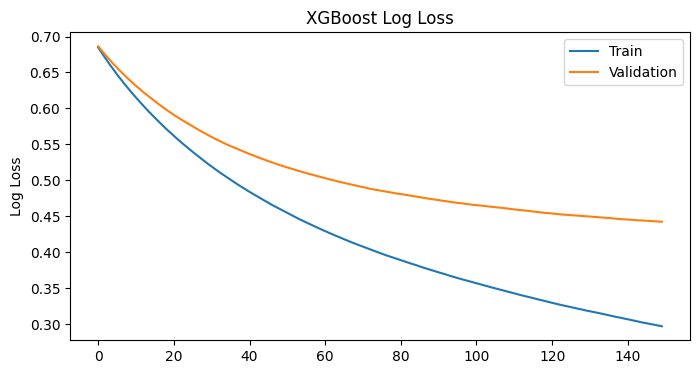

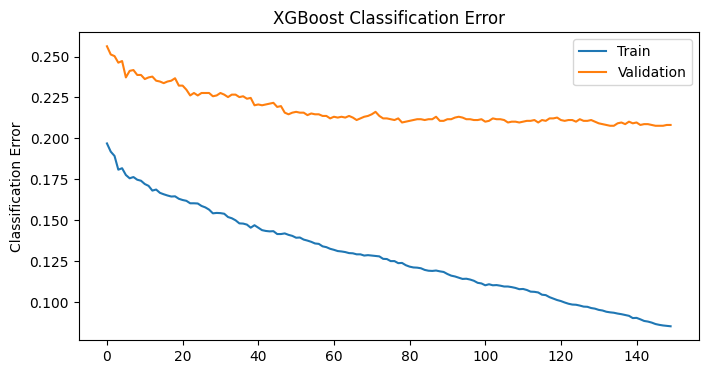

              precision    recall  f1-score   support

           0       0.89      0.38      0.54       500
           1       0.61      0.95      0.74       500

    accuracy                           0.67      1000
   macro avg       0.75      0.67      0.64      1000
weighted avg       0.75      0.67      0.64      1000

Execution time: 372.39746141433716 seconds


/tmp/ipykernel_52636/2551013453.py:530: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_10 (Dropout)           (None, 128)          0           ['dense_25[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19679	validation_0-logloss:0.68479	validation_1-error:0.27828	validation_1-logloss:0.68662
[1]	validation_0-error:0.19317	validation_0-logloss:0.67673	validation_1-error:0.27127	validation_1-logloss:0.68046
[2]	validation_0-error:0.18277	validation_0-logloss:0.66877	validation_1-error:0.25826	validation_1-logloss:0.67427
[3]	validation_0-error:0.17877	validation_0-logloss:0.66111	validation_1-error:0.25626	validation_1-logloss:0.66851
[4]	validation_0-error:0.17827	validation_0-logloss:0.65381	validation_1-error:0.25776	validation_1-logloss:0.66289
[5]	validation_0-error:0.17576	validation_0-logloss:0.64670	validation_1-error:0.24875	validation_1-logloss:0.65748
[6]	validation_0-error:0.17439	validation_0-logloss:0.63968	validation_1-error:0.24474	validation_1-logloss:0.65218
[7]	validation_0-error:0.17539	validation_0-logloss:0.63303	validation_1-error:0.24725	validation_1-logloss:0.64730
[

[70]	validation_0-error:0.12732	validation_0-logloss:0.40668	validation_1-error:0.22022	validation_1-logloss:0.49969
[71]	validation_0-error:0.12707	validation_0-logloss:0.40463	validation_1-error:0.22322	validation_1-logloss:0.49872
[72]	validation_0-error:0.12644	validation_0-logloss:0.40254	validation_1-error:0.22122	validation_1-logloss:0.49771
[73]	validation_0-error:0.12606	validation_0-logloss:0.40051	validation_1-error:0.22122	validation_1-logloss:0.49688
[74]	validation_0-error:0.12519	validation_0-logloss:0.39847	validation_1-error:0.21872	validation_1-logloss:0.49596
[75]	validation_0-error:0.12506	validation_0-logloss:0.39644	validation_1-error:0.21972	validation_1-logloss:0.49492
[76]	validation_0-error:0.12356	validation_0-logloss:0.39453	validation_1-error:0.22072	validation_1-logloss:0.49392
[77]	validation_0-error:0.12206	validation_0-logloss:0.39252	validation_1-error:0.22072	validation_1-logloss:0.49276
[78]	validation_0-error:0.12206	validation_0-logloss:0.39068	val

[140]	validation_0-error:0.08650	validation_0-logloss:0.30638	validation_1-error:0.20971	validation_1-logloss:0.45429
[141]	validation_0-error:0.08563	validation_0-logloss:0.30527	validation_1-error:0.21121	validation_1-logloss:0.45382
[142]	validation_0-error:0.08563	validation_0-logloss:0.30433	validation_1-error:0.21021	validation_1-logloss:0.45358
[143]	validation_0-error:0.08563	validation_0-logloss:0.30345	validation_1-error:0.20871	validation_1-logloss:0.45324
[144]	validation_0-error:0.08513	validation_0-logloss:0.30229	validation_1-error:0.20721	validation_1-logloss:0.45288
[145]	validation_0-error:0.08500	validation_0-logloss:0.30141	validation_1-error:0.20771	validation_1-logloss:0.45244
[146]	validation_0-error:0.08488	validation_0-logloss:0.30047	validation_1-error:0.20821	validation_1-logloss:0.45211
[147]	validation_0-error:0.08425	validation_0-logloss:0.29963	validation_1-error:0.20921	validation_1-logloss:0.45183
[148]	validation_0-error:0.08400	validation_0-logloss:0.

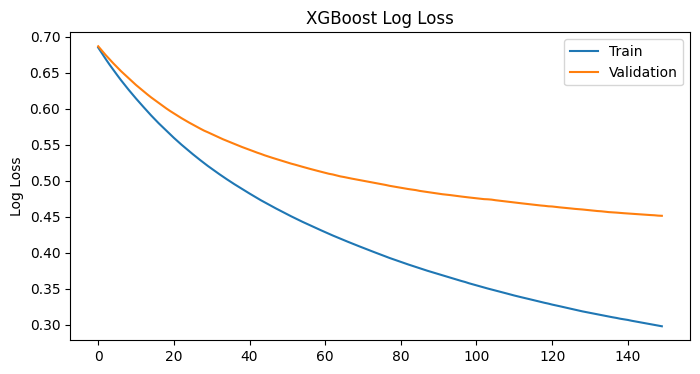

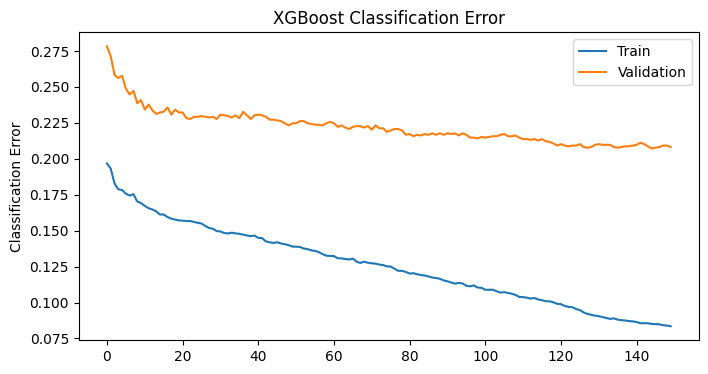

              precision    recall  f1-score   support

           0       0.87      0.46      0.60       500
           1       0.63      0.93      0.76       500

    accuracy                           0.70      1000
   macro avg       0.75      0.70      0.68      1000
weighted avg       0.75      0.70      0.68      1000

Execution time: 381.76904106140137 seconds


/tmp/ipykernel_52636/2551013453.py:530: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


In [4]:
### TRAINING

df_BLPCLPXGB = pd.DataFrame(columns=['Model', 'Accuracy', 
                       'M-Precision', 'M-Recall', 
                       'M-F1-Score', 'W-Precision',
                       'W-Recall', 'W-F1-Score', 'Runtime'])


mse_val1 = []
KL_LOSS1 = []

# Store results in DataFrame
xgboost_clsfn_errrep  = pd.DataFrame(columns=["Bootstrap_Sample_Seed", "Train_LogLoss",
                                              "Validation_LogLoss", "Train_Error",
                                              "Validation_Error"])



for KK in list([7,10,18,22,55,77]):
    
    start_time = time.time()

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)


    device = "cpu"

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    model.to(device)
    projection_layer = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer.to(device)

    train_encodings = tokenizer(
        train["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings = tokenizer(
        test["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )


    with torch.no_grad():
        train_outputs = model(**train_encodings.to(device))
        train_embeddings = train_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings = projection_layer(train_embeddings)  # Project embeddings to size 65

        test_outputs = model(**test_encodings.to(device))
        test_embeddings = test_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings = projection_layer(test_embeddings)  # Project embeddings to size 65

    train_embeddings = train_embeddings.cpu().numpy()
    test_embeddings = test_embeddings.cpu().numpy()

    print("train embeddings shape:", train_embeddings.shape)
    print("test embeddings shape:", test_embeddings.shape)





    # CLIP Image Embeddings (Training Image Embeddings)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP



    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

    #  watch -n 2 nvidia-smi


    # model_16

    # Define the directory containing the images
    IDs = []  #set1
    images = []
    image_dir = "./TRAINING"
    # # Load the data
    train2 = pd.read_csv('./training1.csv', delimiter='\t')

    # Get a list of image filenames in the directory
    filenames = natsort.natsorted(os.listdir(image_dir))
    # len(image_filenames)

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(filenames):
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            ID = filename
            pathname = os.path.join(image_dir, filename)
            im = Image.open(pathname)
    #         print(im.size)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            imnp = np.array(im)
            if len(imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue
            IDs.append(ID)
            images.append(imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    list1 = IDs
    list2 = list(train2.file_name)  #from the text file where we have text description 
    common_strings = get_common_strings(list1, list2)
    print('len of common strings', len(common_strings))

    image_filenames = natsort.natsorted(common_strings)
    # display(image_filenames)

    import pandas as pd

    train_labelset = train2[['file_name', 'misogynous']]
    IDs_df = pd.DataFrame({'file_name': image_filenames})
    joined_df = IDs_df.merge(train_labelset, on='file_name', how='left')
    misogynous_labels = joined_df['misogynous'].tolist()


    #######################################################################


    # Create an empty list to store the image features
    all_image_features_16 = []


    model_16, preprocess_16 = clip.load('ViT-B/16', device=device)

    # Process each image and extract features
    for filename in image_filenames:
        image_path = os.path.join(image_dir, filename)
        imggg = Image.open(image_path)

        imggg = add_salt_and_pepper(imggg)
        # Preprocess the image
        image_16 = preprocess_16(imggg).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features_16 = model_16.encode_image(image_16)

        # Append the image features to the list
        all_image_features_16.append(image_features_16)

    # Concatenate the image features into a single tensor
    all_image_features_16 = torch.cat(all_image_features_16, dim=0)
    print(all_image_features_16.shape)
    # torch.Size([9986, 512])



    ## REDUCE 512 EMBEDDING SIZE TO 64 EMBEDDING SIZE #####
    #######################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    embedding_size = 64
    all_image_features_16_cpu = all_image_features_16.cpu()
    all_image_features_16_numpy = all_image_features_16_cpu.numpy()



    ## using the below Sampling class from WK08 lab tutorials. 
    class Sampling(layers.Layer):


        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
            Sampling from the distribution of z_mu and z_var helps in 
            generating new point in latent space which we can pass to the decoder network 
            to reconstruct the data samples similar to original input
        """
        def call(self, inputs):

            #the encoder network produces a mean and a variance for each dimension of the latent space.
            z_mean, z_log_var = inputs

            # epsilon is not a weight (ie is not learned) and is not calculated based on 
            # the output of the previous layer.
            # epsilon is just a constant Tensor (a new one, each time we call this layer).


            epsilon = K.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
            return z_mean + K.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)


    # for the encoder part, now the original dimension would be the pretrained model output flattened features
    # dimension
    original_dim = all_image_features_16_numpy.shape[1] 
    intermediate_dim = 128  
    intermediate_dim_1 = 64

    latent_dim = embedding_size  # i.e. 18, we set latent dimension to be of embedding size i.e. 18.

    # Define Input to the encoder 
    #Encoder Model Structure
    original_inputs = layers.Input(shape=(original_dim,), name="encoder_input")
    x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim_1, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))   #updated
    encoder = models.Model(inputs=original_inputs, outputs=z, name="encoder") 
    # encoder = models.Model(inputs=original_inputs, outputs=[z_mean, z_log_var], name="encoder")


    #decoder model
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(intermediate_dim_1, activation="relu")(latent_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim, activation="relu")(x)
    outputs = layers.Dense(original_dim, activation="sigmoid")(x)
    decoder = models.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

    # z = Sampling()((z_mean, z_log_var))
    outputs = decoder(z)
    vae = models.Model(inputs=original_inputs, outputs=outputs, name="vae")
    vae.summary()

    #get the reconstruction loss
    reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
    reconstruction_loss = original_dim * K.mean(reconstruction_loss)

    # regularization KL divergence term encourages the learned latent space to be a smooth manifold.
    kl_loss = -0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(kl_loss)
    vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
    vae.add_loss(reconstruction_loss)
    vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

    # set Adam optimizer with learning ate 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    #Compile the model 
    vae.compile(optimizer)

    # Train. x_train is both the "x" and the "y"
    # vae.fit(flat_features, flat_features, epochs=10)

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    vaemod = vae.fit(all_image_features_16_numpy, all_image_features_16_numpy, epochs=10)
    # Increasing the epochs performing badly when we run k-neareast neighbour to achieve the 
    # nearest posters. 

    #In this code, we first need to build the vae model before using encoder.predict(). 
    #This is because the encoder model is a part of the vae model and needs to be built first.

    ## KL LOSS

    KL_LOSS =  vaemod.history['kl_loss']

    KL_LOSS1.append(KL_LOSS)

    mse_val =  vaemod.history['mse_loss']
    print(mse_val)

    mse_val1.append(mse_val)


    latent_emb = encoder.predict(all_image_features_16_numpy)  
    # z_mean, z_log_var = encoder.predict(all_image_features_16_numpy)
    # latent_emb = Sampling()((z_mean, z_log_var))
    print(latent_emb.shape) 

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')





    # CLIP Image Embeddings (Test Image Embeddings)

    # TEST DATA IMAGES LOADING


    TEST_IDs = []  #set1
    TEST_images = []
    TEST_directory = './TEST'   # directory where we have images 
    test_filenames = natsort.natsorted(os.listdir(TEST_directory))  

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(test_filenames):
    #     print(i, filename)
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            TEST_ID = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_imnp = np.array(im)
            if len(TEST_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_imnp.shape, filename)
                continue
            TEST_IDs.append(TEST_ID)
            TEST_images.append(TEST_imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    TEST_list1 = TEST_IDs
    TEST_list2 = list(test2.file_name)  #from the text file where we have text description 
    TEST_common_strings = get_common_strings(TEST_list1, TEST_list2)
    print('len of common strings', len(TEST_common_strings))

    TEST_sorted_ids = natsort.natsorted(TEST_common_strings)
    # len(TEST_sorted_ids)


    TEST_IDs1 = []
    TEST_images1 = [] 
    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(TEST_sorted_ids):
    #     print(i, filename)
        if filename.endswith(".jpg"):
            TEST_ID_0 = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_1_imnp = np.array(im)
            if len(TEST_1_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_1_imnp.shape, filename)
                continue
    #         print('Filename', TEST_ID_0)
            TEST_IDs1.append(TEST_ID_0)
            TEST_images1.append(TEST_1_imnp)


    len(TEST_images1), len(TEST_IDs1)


    #### TEST EMBEDDINGS #####
    clip_test_embeddings = []

    for image in TEST_images1:
        # Preprocess the image
        image_tensor = preprocess_16(Image.fromarray(image)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features = model_16.encode_image(image_tensor)

        # Append the image features to the list
        clip_test_embeddings.append(image_features)

    clip_test_embeddings = torch.cat(clip_test_embeddings, dim=0)

    # Move the test embeddings tensor to the CPU
    clip_test_embeddings = clip_test_embeddings.cpu()

    # Convert the test embeddings tensor to a NumPy array
    clip_test_embeddings_np = clip_test_embeddings.numpy()

    # Use the existing encoder to reduce the dimensions of the test embeddings
    reduced_test_embeddings  = encoder.predict(clip_test_embeddings_np)
    # z_mean_clipmod, z_log_var_clipmod = encoder.predict(clip_test_embeddings_np)
    # reduced_test_embeddings = Sampling()((z_mean_clipmod, z_log_var_clipmod))

    print('Image Test Embeddings Dimension', reduced_test_embeddings.shape)



    if os.getcwd() != "/home/nitesh/Documents/MY_THESIS/MAMI/BLIP":
        %cd BLIP
    print(os.getcwd())

    # Load the training captions data and test captions data files. 
    train_capn = pd.read_csv('train_BLIP_captions.csv')

    test_capn = pd.read_csv('test_BLIP_captions.csv')



    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP

    from transformers import DistilBertTokenizer, DistilBertModel
    tokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model1 = DistilBertModel.from_pretrained("distilbert-base-uncased")


    device = "cpu"
    model1.to(device)
    projection_layer1 = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer1.to(device)

    train_encodings1 = tokenizer1(
        train_capn["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings1 = tokenizer1(
        test_capn["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        train_outputs1 = model1(**train_encodings1.to(device))
        train_embeddings1 = train_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings1 = projection_layer1(train_embeddings1)  # Project embeddings to size 65

        test_outputs1 = model1(**test_encodings1.to(device))
        test_embeddings1 = test_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings1 = projection_layer1(test_embeddings1)  # Project embeddings to size 65


    # Concatenate the text and image embeddings
    fusion_embeddings_train = np.concatenate((train_embeddings, latent_emb, train_embeddings1), axis=1)
    print('Fusion Embeddings Train', fusion_embeddings_train.shape)


    # Concatenate the text and image embeddings
    fusion_embeddings_test = np.concatenate((test_embeddings, reduced_test_embeddings, test_embeddings1), axis=1)
    print('Fusion Embeddings Test', fusion_embeddings_test.shape)


    import pickle
    # Save the embeddings as a pickle object
    pickle_path_train = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/5_fusion_embeddings_train_sp_{KK}.pkl"
    with open(pickle_path_train, 'wb') as f:
        pickle.dump(fusion_embeddings_train, f)

    # Save the embeddings as a pickle object
    pickle_path_test = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/5_fusion_embeddings_test_sp_{KK}.pkl"
    with open(pickle_path_test, 'wb') as f:
        pickle.dump(fusion_embeddings_test, f)


    from sklearn.model_selection import train_test_split
    import xgboost as xgb 
    train_lbls = train.label.map({'non_misogyn': 0, 'misogyn': 1})

    X_train, X_test, y_train, y_test = train_test_split(fusion_embeddings_train, train_lbls, 
                                                        test_size=0.20, random_state=7)

    # Initialize the XGBoost Classifier
    xgb_classifier = xgb.XGBClassifier(n_estimators=150, learning_rate=0.02)

    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_classifier.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

    from matplotlib import pyplot
    import matplotlib.pyplot as plt

    results = xgb_classifier.evals_result()
    epochs = len(results["validation_0"]["error"])
    x_axis = range(0, epochs)


    # plot log loss
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
    ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
    ax.legend()
    pyplot.ylabel("Log Loss")
    pyplot.title("XGBoost Log Loss")
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["error"], label="Train")
    ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
    ax.legend()
    pyplot.ylabel("Classification Error")
    pyplot.title("XGBoost Classification Error")
    pyplot.show()


    row_data = {
        "Bootstrap_Sample_Seed": KK,
        "Train_LogLoss": results["validation_0"]["logloss"],
        "Validation_LogLoss": results["validation_1"]["logloss"],
        "Train_Error": results["validation_0"]["error"],
        "Validation_Error": results["validation_1"]["error"]
    }
    xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


    # Make predictions on the test set
    from sklearn.metrics import classification_report 

    y_pred = xgb_classifier.predict(fusion_embeddings_test)
    # test_lbls = test.label

    test_lbls = test.label.map({'non_misogyn': 0, 'misogyn': 1})
    print(classification_report(test_lbls, y_pred))
    #     print(classification_report(test["label"].tolist(), y_pred))

    report_clip_blip_xgboost = classification_report(test_lbls, y_pred, digits=3)
    #     report_clip_blip_xgboost = classification_report(test["label"].tolist(), y_pred, digits=3)
    #     print(classification_report(test["label"].tolist(), y_pred))


    end_time = time.time()
    execution_time1 = end_time - start_time

    print(f"Execution time: {execution_time1} seconds")

    modname = 'DistilBERT_ViT_VAE_BLIP_XGBOOST_SP'
    df1 = export_classification_report(report_clip_blip_xgboost, modname, execution_time1)
    df_BLPCLPXGB = pd.concat([df_BLPCLPXGB, df1])
    
    os.chdir("/home/nitesh/Documents/MY_THESIS/MAMI")

    del start_time, tokenizer, model, projection_layer
    del train_encodings, test_encodings, train_outputs, test_outputs
    del train_embeddings, test_embeddings
    del IDs, images, image_dir, train2, filenames, common_strings, image_filenames
    del train_labelset, IDs_df, joined_df, misogynous_labels
    del all_image_features_16, model_16, preprocess_16
    del all_image_features_16_cpu, all_image_features_16_numpy
    del Sampling, original_dim, intermediate_dim, intermediate_dim_1, latent_dim
    del original_inputs, x, z_mean, z_log_var, z, encoder
    del latent_inputs, outputs, decoder, vae, optimizer, reconstruction_loss, kl_loss
    del latent_emb, TEST_IDs, TEST_images, TEST_directory, test_filenames, TEST_common_strings
    del TEST_sorted_ids, TEST_IDs1, TEST_images1, clip_test_embeddings, clip_test_embeddings_np
    del reduced_test_embeddings, train_capn, test_capn

    # display(xgboost_clsfn_errrep)



In [5]:
xgboost_clsfn_errrep

,Bootstrap_Sample_Seed,Train_LogLoss,Validation_LogLoss,Train_Error,Validation_Error
0,7,"[0.685179, 0.677546, 0.670204, 0.663053, 0.656...","[0.687271, 0.681485, 0.676001, 0.670615, 0.665...","[0.202053, 0.194917, 0.194291, 0.191788, 0.184...","[0.29029, 0.278278, 0.271772, 0.267267, 0.2642..."
1,10,"[0.68461, 0.676328, 0.668386, 0.660634, 0.6532...","[0.686582, 0.680085, 0.673842, 0.667815, 0.662...","[0.195669, 0.183776, 0.181272, 0.175764, 0.180...","[0.275275, 0.257758, 0.255756, 0.252753, 0.251..."
2,18,"[0.684916, 0.677001, 0.669392, 0.661956, 0.654...","[0.686531, 0.680265, 0.674179, 0.668165, 0.662...","[0.198047, 0.196044, 0.191913, 0.190411, 0.190...","[0.263263, 0.258258, 0.259259, 0.254254, 0.246..."
3,22,"[0.685066, 0.67726, 0.669767, 0.662453, 0.6552...","[0.686577, 0.680336, 0.674336, 0.668503, 0.662...","[0.202929, 0.202429, 0.200676, 0.198047, 0.190...","[0.262262, 0.26026, 0.256757, 0.261261, 0.2552..."
4,55,"[0.684766, 0.676742, 0.66899, 0.661443, 0.6541...","[0.686425, 0.679992, 0.673721, 0.6677, 0.66183...","[0.19692, 0.191913, 0.189284, 0.180896, 0.1817...","[0.256256, 0.251251, 0.25025, 0.246246, 0.2472..."
5,77,"[0.684794, 0.676727, 0.668772, 0.661112, 0.653...","[0.686617, 0.680456, 0.674268, 0.668508, 0.662...","[0.196795, 0.193165, 0.182774, 0.178768, 0.178...","[0.278278, 0.271271, 0.258258, 0.256256, 0.257..."


In [6]:
# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/5_xgboost_clsfn_errrep_SP.csv'

xgboost_clsfn_errrep.to_csv(csv_file, index=False)

In [7]:
# df_BLPCLPXGB
# mse_val1[0]

## VAE TRAINING LOSS VS EPOCH PLOT [SAVE PLOT]

In [8]:
num_lists = len(mse_val1)  # Number of lists
epochs = range(1, 11)  # Epochs (assuming 10 epochs)

# AX=[7,10,18,22,55,77]
# Plot each list in mse_val1
for i,j in zip(range(num_lists), list([7,10,18,22,55,77])):         
    plt.plot(epochs, mse_val1[i], label=f'MSE Loss vs Epochs Sample={j}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Value')
    plt.title('MSE Value vs. Epochs for')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'5_VAE_TrainingLoss_Epoch_Plot_SP_{j}.png')


    plt.legend()
    plt.close()

## SAVE MSE ERROR RESULTS CORRESPONDING TO VAE TRAINING 

In [9]:

# csv_file ='/home/nitesh/Documents/MY_THESIS/MAMI/Plots/VAE_MSE_VALUES'
# Write mse_val1 to CSV file
df = pd.DataFrame(mse_val1)

# Save the DataFrame to a CSV file
# df.to_csv(csv_file, index=False)

# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/5_VAE_training_loss_epochs_SP.csv'

df.to_csv(csv_file, index=False)


## SAVE THE CLASSIFICATION REPORT ERROR TO LOCAL 

In [11]:
df_BLPCLPXGB.to_excel('5_classification_report_DistilBERT_ViT_VAE_BLIP_XGBOOST_SP.xlsx', index=False)

https://xgboost.readthedocs.io/en/stable/parameter.html

refer aboev document for classification error and  logloss error